# Esame di Probabilità e Statistica 18 Settembre 2025

##  Carlo Bruno Torreggiani

In questo notebook si è inizialmente studiato la distribuzione del numero dei comuni divisi per numero di abitanti e di come la popolazione totale si distribuisca in tali comuni. Successivamente, si è analizzato l'andamento del tasso di crescita dei comuni per numero di abitanti, con un focus su quelli con tasso negativo. 

In [40]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats 
import scipy
import seaborn as sns
import matplotlib.pylab as plt
from PIL import Image
import os
import re
from matplotlib import animation
from scipy.stats import chi2


In [41]:

inData_Residenti = pd.read_excel("Residenti.xlsx", header = 1)
inData_Iscritti = pd.read_excel("iscritti.xlsx", header = 1)
inData_Cancellati = pd.read_excel("Cancellati.xlsx", header = 1)


# Rimuovo spazi dai nomi delle colonne per coerenza
inData_Residenti.columns = inData_Residenti.columns.str.strip()
inData_Iscritti.columns = inData_Iscritti.columns.str.strip()
inData_Cancellati.columns = inData_Cancellati.columns.str.strip()


In [42]:
# tolgo l'ultima riga perché risulta vuota
inData_Cancellati = inData_Cancellati.drop(inData_Cancellati.index[-1])
inData_Residenti = inData_Residenti.drop(inData_Residenti.index[-1])
inData_Iscritti = inData_Iscritti.drop(inData_Iscritti.index[-1])

## Analisi qualitativa della popolazione contenuta nei comuni italiani

Si vuole studiare qualitativamente l'andamento della popolazione nei vari comuni italiani. Per farlo, ci si interessa di come varia il numero dei comuni per numero di abitanti, osservando anche come varia nel corso degli anni. Inoltre, ci si chiede se la popolazione è contenuta nella maggior parte in comuni grandi o piccoli e di come tale percentuale cambia nel tempo.

### Studio del numero di comuni divisi per numero di abitanti

In [43]:
# Creo una tabella che mi mostra i numeri di comuni divisi per numero di abitanti (2001) 

# Creo intervalli (bin) da 0 a 20000 con passo 1000
bins = list(range(0, 21000, 1000))

# Etichette per gli intervalli
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# Assegno a ogni comune l'intervallo di appartenenza
intervalli = pd.cut(inData_Residenti["2001"], bins=bins, labels=labels, right=False)

# Calcolo il numero di comuni per ogni intervallo senza somma cumulativa
conteggio_per_intervallo = intervalli.value_counts().sort_index()

# Creo la tabella finale
tabella = pd.DataFrame({'Intervallo popolazione': conteggio_per_intervallo.index,
                        'Numero comuni nel 2001': conteggio_per_intervallo.values})

print(tabella)

   Intervallo popolazione  Numero comuni nel 2001
0                   0-999                    1394
1               1000-1999                    1027
2               2000-2999                     632
3               3000-3999                     428
4               4000-4999                     343
5               5000-5999                     234
6               6000-6999                     179
7               7000-7999                     163
8               8000-8999                     116
9               9000-9999                      84
10            10000-10999                      80
11            11000-11999                      67
12            12000-12999                      54
13            13000-13999                      46
14            14000-14999                      36
15            15000-15999                      37
16            16000-16999                      27
17            17000-17999                      21
18            18000-18999                      19


In [44]:
# Faccio una GIF con gli istogrammi negli anni

inData_Residenti_filtrato = inData_Residenti[inData_Residenti['2001'] < 100000]
anni = [col for col in inData_Residenti_filtrato.columns if col != 'Territorio']

fig, ax = plt.subplots(figsize=(10,6))

# Impostazione limiti fissi prima dell'animazione
ax.set_xlim(0, 100000)
ax.set_ylim(0, 1600)
ax.grid(True)

def update(frame):
    ax.cla()  # pulisce la figura
    anno = anni[frame]
    data = pd.to_numeric(inData_Residenti_filtrato[anno], errors='coerce').dropna()
    ax.hist(data, bins=100, color='skyblue')
    ax.set_title(f'Distribuzione popolazione comuni - {anno}')
    ax.set_xlabel('Popolazione')
    ax.set_ylabel('Numero di comuni')
    # Riassegno limiti fissi e disabilito autoscale
    ax.set_xlim(0, 100000)
    ax.set_ylim(0, 1600)
    ax.autoscale(enable=False)
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(anni), repeat=True)
ani.save('popolazione_comuni.gif', writer='pillow', fps=1)
plt.close(fig)


![Popolazione Comuni](popolazione_comuni.gif)

Si può osservare che il numero di comuni con poche persone è nettamente maggiore di quelli con molte persone. Tale andamento non varia in modo considerevole nel corso degli anni. Sembra però che ci sia una piccola crescita nel numero di comuni con meno di 1.000 abitanti, mentre nelle fasce immediatamente successive sembra che ci sia una tendenza a diminuire. Potrebbe significare che i piccoli comuni tendono a svuotarsi e quindi a popolare maggiormente la fascia 0-1000?

### Analisi qualitativa della distribuzione della popolazione nei comuni

In [45]:

# Creo cartella di output
cartella_output = os.path.join(os.getcwd(), 'popolazione_plots')
os.makedirs(cartella_output, exist_ok=True)

# Ottengo lista anni con dati numerici (ad esempio 2002, 2003, ..., 2019)

for anno in anni:
    residente_anno = inData_Residenti.loc[inData_Residenti['Territorio'] != 'Italia'].copy()
    residente_anno.loc[:, anno] = pd.to_numeric(residente_anno[anno], errors='coerce')
    
    bin_edges = list(range(0, int(residente_anno[anno].max()) + 10000, 5000))
    labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
    residente_anno.loc[:, 'Fascia'] = pd.cut(residente_anno[anno], bins=bin_edges, labels=labels, right=False)
    
    summary = residente_anno.groupby('Fascia', observed=True)[anno].sum()
    total = residente_anno[anno].sum()
    percent = summary / total * 100
    
    tabella = pd.DataFrame({
        'Fascia abitanti': percent.index,
        'Percentuale popolazione': percent.values
    })
    
    filtered_tabella = tabella[tabella['Percentuale popolazione'] > 0].reset_index(drop=True)
    filtered_tabella['Percentuale cumulativa'] = filtered_tabella['Percentuale popolazione'].cumsum()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_tabella['Fascia abitanti'], filtered_tabella['Percentuale popolazione'], alpha=0.7, label='Percentuale popolazione')
    plt.plot(filtered_tabella['Fascia abitanti'], filtered_tabella['Percentuale cumulativa'], color='red', marker='o', label='Percentuale cumulativa')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Fascia abitanti')
    plt.ylabel('Percentuale (%)')
    plt.title(f'Distribuzione Percentuale della Popolazione per Fasce di Abitanti ({anno})')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    
    # Salvo plot
    nome_file = os.path.join(cartella_output, f'popolazione_{anno}.png')
    plt.savefig(nome_file)
    plt.close()


In [46]:

cartella_plot = os.path.join(os.getcwd(), 'popolazione_plots')
file_names = sorted([f for f in os.listdir(cartella_plot) if f.endswith('.png')])

# Carico immagini
frames = [Image.open(os.path.join(cartella_plot, f)) for f in file_names]

# Salvo GIF
output_gif_path = os.path.join(os.getcwd(), 'popolazione.gif')
frames[0].save(
    output_gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=1000,  # durata frame in ms (1000 = 1 secondo)
    loop=0  # loop infinito
)

print(f"GIF salvata in: {output_gif_path}")


GIF salvata in: C:\Users\carlo\popolazione.gif


![Popolazione Comuni](popolazione.gif)

Si nota che la maggior parte della popolazione (50%) è contenuta nella parte di comuni che hanno meno di 20.000 abitanti. Un contributo considerevole è anche dato dalle poche grandi città. Effettivamente, il contributo percentuale del primo bin 0-5000 è in decrescita. Anche questa analisi sembra far intendere che i piccoli comuni in questo lasso di tempo si stanno depopolando, mentre i comuni più grandi diventino più popolosi.

## Andamento della decrescita dei piccoli comuni italiani 

In questa sezione viene analizzato il tasso di crescita dei piccoli comuni italiani, considerando quelli che hanno meno di 10.000 abitanti. 

### Percentuale di comuni in decrescita

Si studia l'andamento qualitativo dei tassi di crescita dei comuni divisi per numero di abitanti. Si costruisce un istogramma impilato che mostra in verde la percentuale di comuni che hanno un tasso di crescita positivo e in verde quelli con tasso negativo.

In [47]:

# Escludo la riga 'Italia'
inData_Residenti_NoTot = inData_Residenti[inData_Residenti['Territorio'] != 'Italia'].copy()
inData_Iscritti_NoTot = inData_Iscritti[inData_Iscritti['Territorio'] != 'Italia'].copy()
inData_Cancellati_NoTot = inData_Cancellati[inData_Cancellati['Territorio'] != 'Italia'].copy()

# Ottengo la lista degli anni (colonne numeriche)
anni = [col for col in inData_Residenti_NoTot.columns if str(col).isdigit()]

# Converto le colonne degli anni in numerico, evitando warning con .loc
for df in [inData_Residenti_NoTot, inData_Iscritti_NoTot, inData_Cancellati_NoTot]:
    for anno in anni:
        df.loc[:, anno] = pd.to_numeric(df[anno], errors='coerce')

# Calcolo saldo migratorio netto (iscritti - cancellati)
saldo = inData_Iscritti_NoTot.set_index('Territorio')[anni] - inData_Cancellati_NoTot.set_index('Territorio')[anni]

# Popolazione residente anno precedente (shiftata)
popolazione = inData_Residenti_NoTot.set_index('Territorio')[anni]
popolazione_shifted = popolazione.shift(axis=1)

# Sostituisco 0 con NaN nel denominatore per evitare divisione per zero
denominator = popolazione_shifted.values
denominator_safe = np.where(denominator == 0, np.nan, denominator)

# Calcolo tasso crescita netto percentuale evitando errori di divisione
with np.errstate(divide='ignore', invalid='ignore'):
    tasso_crescita_netto = saldo.values / denominator_safe
    tasso_crescita_netto = tasso_crescita_netto * 100

tasso_crescita_netto = pd.DataFrame(tasso_crescita_netto, index=saldo.index, columns=saldo.columns)


In [48]:

cartella_output = os.path.join(os.getcwd(), 'gif')
os.makedirs(cartella_output, exist_ok=True)

# Escludo 2001 e 2019 dagli anni
anni = [anno for anno in anni if anno not in ['2001', '2019']]


# Calcolo il limite massimo y per uniformare gli assi
max_y = 0
for anno_riferimento in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno_riferimento].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno_riferimento]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    # Filtro comuni con popolazione < 10000
    df_small = df[df['popolazione'] < 10000].copy()
    bins = np.arange(0, 10000 + 1000, 1000)
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, right=False)
    df_small['crescita_cat'] = np.where(df_small['tasso_crescita'] >= 0, 'Positivo', 'Negativo')
    count_df = df_small.groupby(['pop_bin', 'crescita_cat'], observed=True).size().unstack(fill_value=0)
    max_y = max(max_y, count_df.values.max())

for anno_riferimento in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno_riferimento].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno_riferimento]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    # Filtro comuni con popolazione < 10000
    df_small = df[df['popolazione'] < 10000].copy()
    bins = np.arange(0, 10000 + 1000, 1000)
    labels = [f'{int(bins[i])}-{int(bins[i+1])-1}' for i in range(len(bins)-1)]
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, labels=labels, right=False)
    df_small['crescita_cat'] = np.where(df_small['tasso_crescita'] >= 0, 'Positivo', 'Negativo')
    count_df = df_small.groupby(['pop_bin', 'crescita_cat'], observed=True).size().unstack(fill_value=0)

    ax = count_df.plot(kind='bar', stacked=True, figsize=(14,7), color=['crimson', 'seagreen'])
    ax.set_xlabel('Fasce di popolazione comunale (abitanti)')
    ax.set_ylabel('Numero di comuni')
    ax.set_title(f'Tasso di crescita positivo/negativo per fasce popolazione\n(Comuni < 10.000 abitanti - Anno {anno_riferimento})')

    # Imposto etichette asse X con margini per evitare taglio
    ax.set_xticks(range(len(count_df.index)))
    ax.set_xticklabels(count_df.index, rotation=45, ha='right')
    ax.margins(x=0.01)

    plt.legend(title='Tasso di crescita')
    plt.grid(axis='y')
    ax.set_ylim(0, max_y * 1.9)  # margine y sopra massimo
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.30, right=0.98, left=0.07, top=0.93)

    nome_file = f'{cartella_output}/istogramma_{anno_riferimento}.png'
    plt.savefig(nome_file)
    plt.close()


In [49]:
# Costruisco la GIF

# Cartella 'gif' dentro la cartella di lavoro corrente
cartella = os.path.join(os.getcwd(), 'gif')

file_list = os.listdir(cartella)

def estrai_anno(nome_file):
    match = re.search(r'(\d{4})', nome_file)
    return int(match.group(1)) if match else 0

file_list_png = sorted(
    [f for f in file_list if f.endswith('.png') and '2019' not in f],
    key=estrai_anno
)

frames = [Image.open(os.path.join(cartella, fname)) for fname in file_list_png]

# Salvo la GIF nella cartella di lavoro corrente (non dentro gif)
output_gif = os.path.join(os.getcwd(), 'istogrammi_animati.gif')

frames[0].save(
    output_gif,
    save_all=True,
    append_images=frames[1:],
    duration=1000,   # durata per frame in millisecondi
    loop=0
)



![Animazione istogrammi](istogrammi_animati.gif)


Sembra che per le fasce più basse ci sia un aumento del numero di comuni con tasso negativo. Si procede con un fit lineare per capire quantitativamente di quanto aumenta il numero di tali comuni. 

### Fit lineare dei comuni in decrescita

Si vuole verificare che l'andamento del numero di comuni in decrescita vari linearmente negli anni. Per farlo, si procede con un fit lineare.

In [50]:

# Definisco fasce di popolazione da 0 a 10000 con step 1000
bins = np.arange(0, 10000 + 1000, 1000)
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# DataFrame per i risultati (anni come indice, fasce come colonne)
decrescita_time = pd.DataFrame(index=anni, columns=labels)

for anno in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno]
    df = pd.DataFrame({
        'popolazione': popolazione_anno,
        'tasso_crescita': tasso_crescita_anno
    })
    # Filtra comuni con popolazione < 10000
    df_small = df[df['popolazione'] < 10000].copy()
    # Assegna fascia di popolazione
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, labels=labels, right=False)
    # Seleziona solo comuni in decrescita (tasso di crescita < 0)
    df_decrescita = df_small[df_small['tasso_crescita'] < 0]
    # Conta i comuni per fascia
    counts = df_decrescita.groupby('pop_bin', observed=True).size()
    # Riempie i NaN con 0 e assegna al DataFrame risultati
    decrescita_time.loc[anno] = counts.reindex(labels, fill_value=0)

# Converte valori a interi
decrescita_time = decrescita_time.astype(int)




Parametri del fit lineare per ciascuna fascia (coeff. angolare, intercetta):
0-999: coeff. angolare = 8.436, intercetta = -16295.853
1000-1999: coeff. angolare = 9.002, intercetta = -17622.162
2000-2999: coeff. angolare = 6.909, intercetta = -13592.368
3000-3999: coeff. angolare = 4.733, intercetta = -9316.603
4000-4999: coeff. angolare = 3.674, intercetta = -7243.132
5000-5999: coeff. angolare = 2.919, intercetta = -5772.250
6000-6999: coeff. angolare = 2.054, intercetta = -4051.382
7000-7999: coeff. angolare = 1.142, intercetta = -2235.147
8000-8999: coeff. angolare = 1.395, intercetta = -2756.338
9000-9999: coeff. angolare = 1.733, intercetta = -3447.015


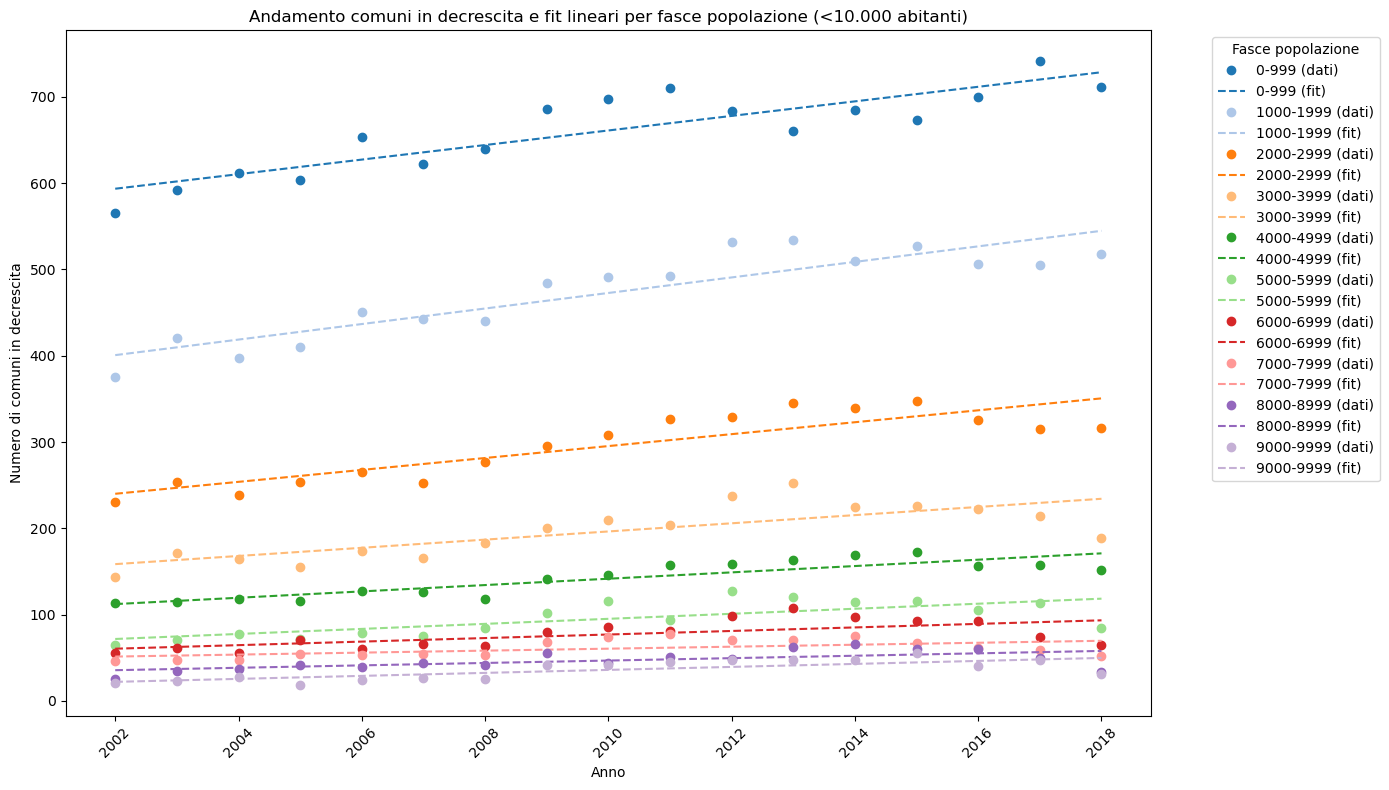

In [51]:

plt.figure(figsize=(14, 8))
x = decrescita_time.index.astype(int).values
colors = plt.cm.tab20.colors  # palette di colori distinti

fits = {}  # Dizionario per salvare i valori del fit per ogni fascia

print("Parametri del fit lineare per ciascuna fascia (coeff. angolare, intercetta):")
for i, fascia in enumerate(labels):
    y = decrescita_time[fascia].values
    color = colors[i % len(colors)]
    
    # Fit lineare
    coeffs = np.polyfit(x, y, deg=1)
    p = np.poly1d(coeffs)
    y_fit = p(x)
    
    # Salva i valori del fit nel dizionario
    fits[fascia] = y_fit
    
    # Stampa parametri del fit
    slope, intercept = coeffs
    print(f"{fascia}: coeff. angolare = {slope:.3f}, intercetta = {intercept:.3f}")
    
    # Plot punti dati
    plt.plot(x, y, marker='o', linestyle='none', color=color, label=f'{fascia} (dati)')
    # Plot linea di fit lineare tratteggiata
    plt.plot(x, y_fit, linestyle='--', color=color, label=f'{fascia} (fit)')

plt.xticks(rotation=45)
plt.xlabel('Anno')
plt.ylabel('Numero di comuni in decrescita')
plt.title('Andamento comuni in decrescita e fit lineari per fasce popolazione (<10.000 abitanti)')
plt.legend(title='Fasce popolazione', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [52]:
# Faccio un fit con i valori percentuali

# DataFrame vuoto per percentuali di comuni in decrescita per ogni anno e fascia
decrescita_percentuale = pd.DataFrame(index=anni, columns=labels)

# Calcolo percentuali per ciascun anno e fascia
for anno in anni:
    popolazione_anno = inData_Residenti_NoTot.set_index('Territorio')[anno].astype(float)
    tasso_crescita_anno = tasso_crescita_netto[anno]
    
    df = pd.DataFrame({'popolazione': popolazione_anno, 'tasso_crescita': tasso_crescita_anno})
    df_small = df[df['popolazione'] < 10000].copy()
    
    # Assegno la fascia di popolazione
    df_small['pop_bin'] = pd.cut(df_small['popolazione'], bins=bins, labels=labels, right=False)
    
    # Conto totale comuni per fascia
    count_all = df_small.groupby('pop_bin', observed = True).size()
    
    # Conto comuni in decrescita per fascia
    count_neg = df_small[df_small['tasso_crescita'] < 0].groupby('pop_bin', observed = True).size()
    
    # Calcolo percentuale comuni in decrescita per fascia
    percent_neg = (count_neg / count_all).fillna(0) * 100
    
    decrescita_percentuale.loc[anno] = percent_neg.values

# Converto in float
decrescita_percentuale = decrescita_percentuale.astype(float)


In [53]:

fits_percentuale = {}  # Dizionario per salvare valori fit per ogni fascia
x = decrescita_percentuale.index.astype(int).values

print("Coefficienti regressione (pendenza, intercetta) per fascia:")
for fascia in labels:
    y = decrescita_percentuale[fascia].values.astype(float)
    
    # Calcolo retta di regressione lineare
    coeffs = np.polyfit(x, y, deg=1)
    p = np.poly1d(coeffs)
    y_fit = p(x)
    
    # Salva valori previsti dal fit in dizionario
    fits_percentuale[fascia] = y_fit
    
    slope, intercept = coeffs
    print(f"{fascia}: coefficiente angolare = {slope:.4f}, intercetta = {intercept:.4f}")


Coefficienti regressione (pendenza, intercetta) per fascia:
0-999: coefficiente angolare = 0.6698, intercetta = -1297.4899
1000-1999: coefficiente angolare = 1.1497, intercetta = -2262.3226
2000-2999: coefficiente angolare = 1.1630, intercetta = -2290.7957
3000-3999: coefficiente angolare = 1.1255, intercetta = -2216.8591
4000-4999: coefficiente angolare = 1.2133, intercetta = -2395.0443
5000-5999: coefficiente angolare = 1.3439, intercetta = -2660.0894
6000-6999: coefficiente angolare = 0.8720, intercetta = -1712.2522
7000-7999: coefficiente angolare = 0.7695, intercetta = -1508.3844
8000-8999: coefficiente angolare = 1.0002, intercetta = -1975.2171
9000-9999: coefficiente angolare = 1.3790, intercetta = -2735.1661


Si è fatto un fit lineare per capire in prima approssimazione l'andamento del numero di comuni in decrescita. Si nota che effettivamente c'è la tendenza all'aumento del numero di comuni con un coefficiente di crescita negativo. Questo può essere causato da due effetti: o tale aumento è causato semplicemente dal fatto che arrivano comuni in decrescita dalle fasce alte o c'è proprio un cambio di trend in ciascun bin. Per verificare quale di questi due effetti contribuisca maggiormente si è calcolato anche l'aumento percentuale: dato che aumenta anch'esso, si può affermare che i comuni dentro ciascun bin cambino il proprio tasso di crescita. Vogliamo ora verificare se l'approssimazione lineare descrive bene l'andamento di questi dati.

#### Test del $\chi^2$ per la verifica della bontà del fit

In [54]:
# Test del chi quadro per i valori assoluti
x = decrescita_time.index.astype(int).values

print("Test del chi-quadro sul fit lineare:")

for fascia in labels:
    y_obs = decrescita_time[fascia].values.astype(float)
    y_exp = fits[fascia]  # utilizza i valori del fit salvati
    
    epsilon = 1e-6
    y_exp_safe = np.where(y_exp < epsilon, epsilon, y_exp)  # evita divisioni per zero
    
    chi_sq_stat = np.sum((y_obs - y_exp_safe)**2 / y_exp_safe)
    df = len(x) - 2  # gradi di libertà (n - numero parametri)
    p_value = 1 - chi2.cdf(chi_sq_stat, df)
    
    print(f"{fascia}: chi2 = {chi_sq_stat:.2f}, df = {df}, p-value = {p_value:.4f}", end=' ')
    if p_value > 0.05:
        print("- buon fit (non si rifiuta H0)")
    else:
        print("- fit non buono (si rifiuta H0)")


Test del chi-quadro sul fit lineare:
0-999: chi2 = 13.26, df = 15, p-value = 0.5819 - buon fit (non si rifiuta H0)
1000-1999: chi2 = 16.52, df = 15, p-value = 0.3484 - buon fit (non si rifiuta H0)
2000-2999: chi2 = 18.16, df = 15, p-value = 0.2541 - buon fit (non si rifiuta H0)
3000-3999: chi2 = 29.86, df = 15, p-value = 0.0124 - fit non buono (si rifiuta H0)
4000-4999: chi2 = 10.21, df = 15, p-value = 0.8066 - buon fit (non si rifiuta H0)
5000-5999: chi2 = 29.68, df = 15, p-value = 0.0131 - fit non buono (si rifiuta H0)
6000-6999: chi2 = 30.85, df = 15, p-value = 0.0092 - fit non buono (si rifiuta H0)
7000-7999: chi2 = 21.11, df = 15, p-value = 0.1335 - buon fit (non si rifiuta H0)
8000-8999: chi2 = 23.24, df = 15, p-value = 0.0792 - buon fit (non si rifiuta H0)
9000-9999: chi2 = 23.33, df = 15, p-value = 0.0774 - buon fit (non si rifiuta H0)


Si osserva che per alcune fasce, soprattutto quelle più basse, il test del $\chi^2$ afferma che l'approssimazione lineare è buona. Ci sono alcune fasce per cui il p-value però è troppo basso e l'ipotesi di linearità dev'essere rifiutata. Vediamo ora quanto è buono il fit per i valori percentuali.

In [55]:

x = decrescita_percentuale.index.astype(int).values

print("Test del chi-quadro sul fit lineare percentuale già calcolato:")

for fascia in labels:
    y_obs = decrescita_percentuale[fascia].values.astype(float)
    y_exp = fits_percentuale[fascia]
    
    epsilon = 1e-6
    y_exp_safe = np.where(y_exp < epsilon, epsilon, y_exp)
    
    chi_sq_stat = np.sum((y_obs - y_exp_safe)**2 / y_exp_safe)
    df = len(x) - 2
    p_value = 1 - chi2.cdf(chi_sq_stat, df)
    
    print(f"{fascia}: chi2 = {chi_sq_stat:.2f}, df = {df}, p-value = {p_value:.4f}", end=' ')
    if p_value > 0.05:
        print("- buon fit (non si rifiuta H0)")
    else:
        print("- fit non buono (si rifiuta H0)")


Test del chi-quadro sul fit lineare percentuale già calcolato:
0-999: chi2 = 1.48, df = 15, p-value = 1.0000 - buon fit (non si rifiuta H0)
1000-1999: chi2 = 1.88, df = 15, p-value = 1.0000 - buon fit (non si rifiuta H0)
2000-2999: chi2 = 2.40, df = 15, p-value = 0.9999 - buon fit (non si rifiuta H0)
3000-3999: chi2 = 6.87, df = 15, p-value = 0.9612 - buon fit (non si rifiuta H0)
4000-4999: chi2 = 2.68, df = 15, p-value = 0.9998 - buon fit (non si rifiuta H0)
5000-5999: chi2 = 14.12, df = 15, p-value = 0.5165 - buon fit (non si rifiuta H0)
6000-6999: chi2 = 15.33, df = 15, p-value = 0.4277 - buon fit (non si rifiuta H0)
7000-7999: chi2 = 13.14, df = 15, p-value = 0.5914 - buon fit (non si rifiuta H0)
8000-8999: chi2 = 17.23, df = 15, p-value = 0.3053 - buon fit (non si rifiuta H0)
9000-9999: chi2 = 19.10, df = 15, p-value = 0.2091 - buon fit (non si rifiuta H0)


In questo caso si vede che per tutte le fasce il p-value risulta maggiore del valore 0.05 e quindi l'ipotesi di andamento lineare dei valori percentuali è verificata. Dato che il calcolo del valore percentuale presuppone dividere il valore assoluto per il numero di comuni totale di ciascun bin, si potrebbe pensare che l'andamento dei valori assoluti sia descritto in modo più fedele da un polinomio di secondo grado. Il p-value per alcune fasce risulta estremamente alto, cosa che potrebbe far pensare al fatto che per questo caso il test del $\chi^2$ non sia utilizzabile perché l'assunzione di gaussianità dei residui non è vera. Ciò è indagato mediante un test di Kolmogorov-Smirnov.


### Fit quadratico dei comuni in decrescita

Si procede analogamente al caso precedente, ma questa volta si calcola il fit con una parabola (polinomio di secondo grado).

Parametri del fit quadratico per ciascuna fascia (coeff. a, b, c):
0-999: a = -0.497420, b = 2008.064758, c = -2025910.540
1000-1999: a = -0.695949, b = 2806.719169, c = -2829310.761
2000-2999: a = -0.539345, b = 2175.074949, c = -2192585.886
3000-3999: a = -0.540119, b = 2176.009933, c = -2191437.115
4000-4999: a = -0.207301, b = 837.025413, c = -844756.307
5000-5999: a = -0.390222, b = 1571.611068, c = -1582298.295
6000-6999: a = -0.349071, b = 1405.320176, c = -1414325.590
7000-7999: a = -0.325851, b = 1311.064758, c = -1318699.540
8000-8999: a = -0.251935, b = 1014.173246, c = -1020592.823
9000-9999: a = -0.182534, b = 735.517673, c = -740896.388


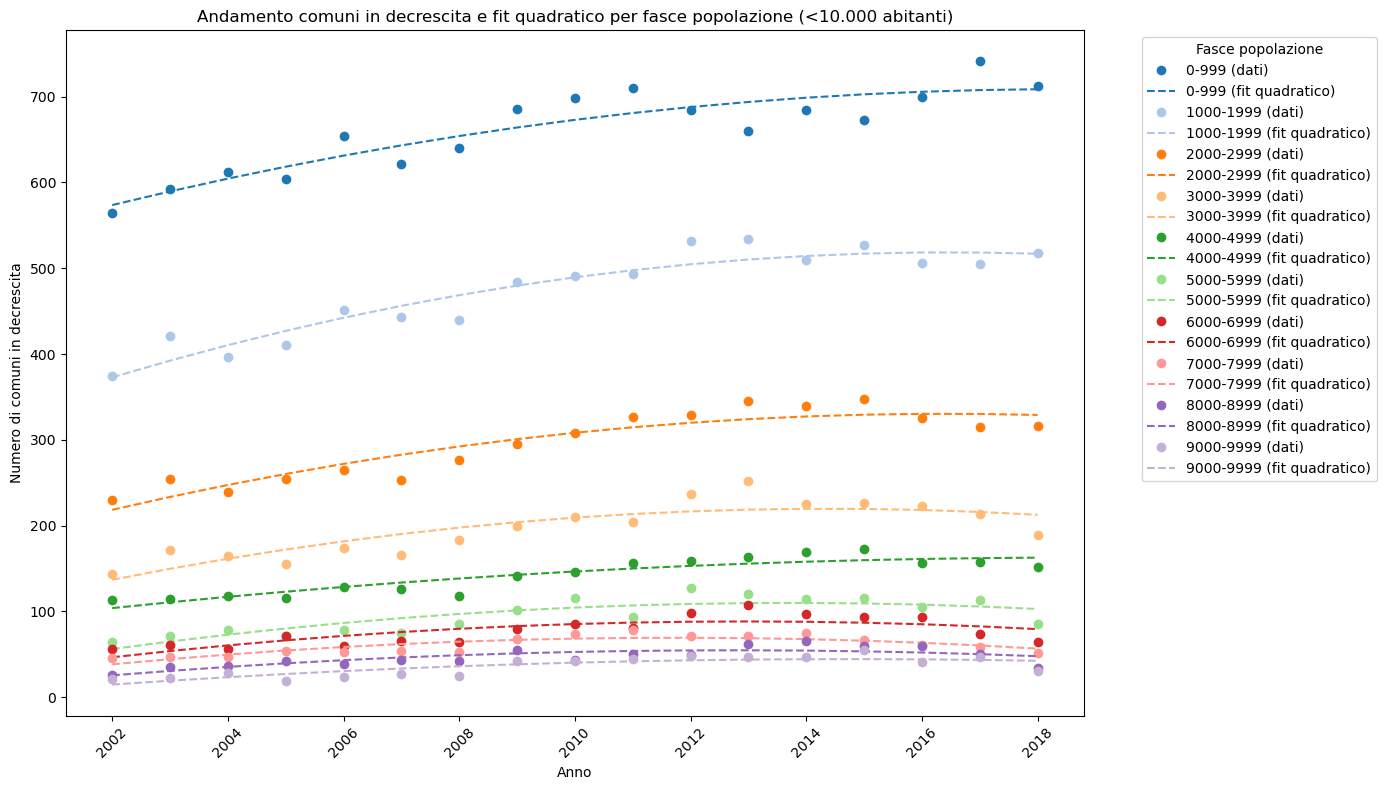

In [56]:

plt.figure(figsize=(14, 8))
x = decrescita_time.index.astype(int).values
colors = plt.cm.tab20.colors  # palette di colori distinti
fits_quadratic = {}  # Dizionario per salvare i valori del fit quadratico per ogni fascia

print("Parametri del fit quadratico per ciascuna fascia (coeff. a, b, c):")
for i, fascia in enumerate(labels):
    y = decrescita_time[fascia].values
    color = colors[i % len(colors)]
    
    # Fit quadratico (grado 2)
    coeffs = np.polyfit(x, y, deg=2)
    p = np.poly1d(coeffs)
    y_fit = p(x)
    
    # Salva i valori del fit nel dizionario
    fits_quadratic[fascia] = y_fit
    
    # Stampa parametri del fit (a x^2 + b x + c)
    a, b, c = coeffs
    print(f"{fascia}: a = {a:.6f}, b = {b:.6f}, c = {c:.3f}")
    
    # Plot punti dati
    plt.plot(x, y, marker='o', linestyle='none', color=color, label=f'{fascia} (dati)')
    # Plot linea di fit quadratico tratteggiata
    plt.plot(x, y_fit, linestyle='--', color=color, label=f'{fascia} (fit quadratico)')

plt.xticks(rotation=45)
plt.xlabel('Anno')
plt.ylabel('Numero di comuni in decrescita')
plt.title('Andamento comuni in decrescita e fit quadratico per fasce popolazione (<10.000 abitanti)')
plt.legend(title='Fasce popolazione', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [57]:

x = decrescita_time.index.astype(int).values

print("Test del chi-quadro sul fit quadratico già calcolato:")

for fascia in labels:
    y_obs = decrescita_time[fascia].values.astype(float)
    y_exp = fits_quadratic[fascia]  # usa il fit quadratico salvato
    
    epsilon = 1e-6
    y_exp_safe = np.where(y_exp < epsilon, epsilon, y_exp)
    
    chi_sq_stat = np.sum((y_obs - y_exp_safe)**2 / y_exp_safe)
    df = len(x) - 3  # gradi di libertà: n - numero parametri (3 per polinomio di grado 2)
    p_value = 1 - chi2.cdf(chi_sq_stat, df)
    
    print(f"{fascia}: chi2 = {chi_sq_stat:.2f}, df = {df}, p-value = {p_value:.4f}", end=' ')
    if p_value > 0.05:
        print("- buon fit (non si rifiuta H0)")
    else:
        print("- fit non buono (si rifiuta H0)")


Test del chi-quadro sul fit quadratico già calcolato:
0-999: chi2 = 10.12, df = 14, p-value = 0.7535 - buon fit (non si rifiuta H0)
1000-1999: chi2 = 9.08, df = 14, p-value = 0.8261 - buon fit (non si rifiuta H0)
2000-2999: chi2 = 11.97, df = 14, p-value = 0.6091 - buon fit (non si rifiuta H0)
3000-3999: chi2 = 20.55, df = 14, p-value = 0.1136 - buon fit (non si rifiuta H0)
4000-4999: chi2 = 8.57, df = 14, p-value = 0.8575 - buon fit (non si rifiuta H0)
5000-5999: chi2 = 19.69, df = 14, p-value = 0.1401 - buon fit (non si rifiuta H0)
6000-6999: chi2 = 21.45, df = 14, p-value = 0.0906 - buon fit (non si rifiuta H0)
7000-7999: chi2 = 8.55, df = 14, p-value = 0.8588 - buon fit (non si rifiuta H0)
8000-8999: chi2 = 14.30, df = 14, p-value = 0.4280 - buon fit (non si rifiuta H0)
9000-9999: chi2 = 20.41, df = 14, p-value = 0.1178 - buon fit (non si rifiuta H0)


Nel caso di fit quadratico si vede che i p-value sono tutti sopra il livello di significatività 0.05 e quindi l'ipotesi di andamento quadratico è accettata. Inoltre si nota anche che i p-value risultano molto più alti del caso lineare anche per i casi in cui tale approssimazione era accettabile: si può dunque affermare che l'approssimazione quadratica è migliore in tutti i casi di quella lineare.

### Verifica dell'ipotesi di gaussianità dei residui per il fit (caso del fit lineare per i valori percentuali)

Si procede a testare l'assunzione che i residui nel caso del fit lineare per i valori percentuali si distribuiscano in modo gaussiano, ipotesi necessaria per fare un test del $\chi^2$ per verificare la bontà dei fit. Si utilizza un test di Kolmogorov-Smirnov per confrontare la distribuzione dei residui con quella gaussiana teorica.

In [59]:

from scipy.stats import kstest

print("Test di Kolmogorov-Smirnov per normalità residui:")
x = decrescita_percentuale.index.astype(int).values
for fascia in labels:
    y_obs = decrescita_percentuale[fascia].values.astype(float)
    y_exp = fits_percentuale[fascia]  # valori previsti dal fit
    
    residui = y_obs - y_exp
    # Normalizza i residui (media 0, varianza 1) 
    residui_norm = (residui - np.mean(residui)) / np.std(residui, ddof=1)
    
    # Test KS contro distribuzione normale standard
    stat, p_value = kstest(residui_norm, 'norm')
    
    print(f"{fascia}: KS statistic = {stat:.4f}, p-value = {p_value:.4f}", end=' ')
    if p_value > 0.05:
        print("- residui compatibili con normalità")
    else:
        print("- residui NON compatibili con normalità")


Test di Kolmogorov-Smirnov per normalità residui:
0-999: KS statistic = 0.1548, p-value = 0.7548 - residui compatibili con normalità
1000-1999: KS statistic = 0.1691, p-value = 0.6550 - residui compatibili con normalità
2000-2999: KS statistic = 0.1797, p-value = 0.5816 - residui compatibili con normalità
3000-3999: KS statistic = 0.1788, p-value = 0.5877 - residui compatibili con normalità
4000-4999: KS statistic = 0.1077, p-value = 0.9768 - residui compatibili con normalità
5000-5999: KS statistic = 0.2116, p-value = 0.3784 - residui compatibili con normalità
6000-6999: KS statistic = 0.0801, p-value = 0.9995 - residui compatibili con normalità
7000-7999: KS statistic = 0.1214, p-value = 0.9379 - residui compatibili con normalità
8000-8999: KS statistic = 0.1577, p-value = 0.7344 - residui compatibili con normalità
9000-9999: KS statistic = 0.1144, p-value = 0.9606 - residui compatibili con normalità


Effettivamente i p-value di questo test risultano tutti molto alti; ciò è indicativo del fatto che la nostra assunzione di gaussianità risulta ben posta e utilizzabile per fare i test del $\chi^2$. Tutta l'analisi fatta sopra è perciò corretta.